In [21]:
import tensorflow as tf
import numpy as np


import pandas as pd
import openpyxl # Needed for reading excel
import pathlib


In [22]:
# SAMPLES = 32
# TIME = 6
# FEATURES = 40
# generator = tf.random.Generator.from_seed(1)
# data = generator.normal(shape=[40, 3])
# X = generator.normal(shape=[SAMPLES, TIME, FEATURES])
# y = generator.normal(shape=[SAMPLES, 2])

In [23]:
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.weighter = tf.keras.layers.Softmax(axis=2)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise Exception("Wrong dimensions")
        
        self.batch_size, self.time_steps, self.number_of_features = input_shape
        
        self.weight = self.add_weight(
            name="att_weight",
            shape=(self.number_of_features, self.number_of_features),
            initializer=tf.keras.initializers.RandomUniform(-0.1, 0.1),
            trainable=True,
        )

        self.bias = self.add_weight(
            name="att_bias",
            shape=(self.number_of_features, ),
            initializer='zeros',
            trainable=True,
        )

        self.score_calculator = lambda x: x @ self.weight + self.bias
        self.averager = lambda x: tf.math.reduce_mean(x, axis=1, keepdims=True)
        self.repeater = lambda x: tf.repeat(x, repeats=self.time_steps, axis=1)

        super().build(input_shape)

    def call(self, inputs):
        attention_score = self.score_calculator(inputs)
        attention_weights = self.weighter(attention_score)
        averaged_attention_weight = self.averager(attention_weights)
        averaged_attention_weights = self.repeater(averaged_attention_weight)

        feature_representation = inputs * averaged_attention_weights
        feature_representation = inputs * attention_score
        
        return feature_representation, attention_score

In [24]:
class IterativeFilterCallback(tf.keras.callbacks.Callback):
    def __init__(self, X, y, model_class, iterations=2, iteration=0, threshold=0.2):
        self.X = X
        self.y = y
        self.iteration = iteration
        self.iterations = iterations
        self.model_class = model_class
        self.threshold = threshold
        
    def on_train_begin(self, logs={}):
        self.attention_scores = []
        self.filtered_indices = []

    def on_train_end(self, logs={}):
        if self.iteration >= self.iterations:
            return
        model = self.model
        attention_weights = model.get_attention_weights(self.X)
        averaged_attention_weights = tf.math.reduce_mean(tf.math.reduce_mean(attention_weights, axis=0), axis=0)

        ######## THIS IS TEMPORARY ########
        self.threshold = tf.reduce_mean(averaged_attention_weights)-.05
        ######## THIS IS TEMPORARY ########
        
        self.mask = averaged_attention_weights >= self.threshold
        self.indices = tf.where(self.mask)
        self.filtered_indices.append(self.indices)

        # Perform the iterative filtering and training process
        filtered_X = tf.squeeze(tf.gather(self.X, self.indices, axis=-1))
        filtered_model = self.model_class()

        filtered_model.compile(
            loss='mse', 
            metrics='mean_squared_error'
            )
        filtered_model.build(filtered_X.shape)

        for orig_layer, filtered_layer in zip(self.model.layers, filtered_model.layers):
            try:
                filtered_layer.set_weights(orig_layer.get_weights())
                print('it worked' + str(filtered_layer))
            except Exception as e:
                print(orig_layer, filtered_layer)
                print(e)
            

        filter_callback = IterativeFilterCallback(filtered_X, y, Model, iterations=self.iterations, iteration=self.iteration+1, threshold=0.1)
        filtered_model.fit(filtered_X, self.y, batch_size=16, epochs=10, callbacks=[filter_callback])
        self.filtered_indices.extend(filter_callback.filtered_indices)


In [25]:
class Model(tf.keras.Model):
    def __init__(self, num_feature_prediction):
        super().__init__()
        
        self.attention = Attention()

        #### STILL PLAYING WITH RETURN_SEQUENCES TRUE/FALSE
        self.lstm2 = tf.keras.layers.LSTM(6, activation='softmax', return_sequences=True)
        # self.lstm = tf.keras.layers.LSTM(128, activation='softmax', return_sequences=False)
        
        self.dense10 = tf.keras.layers.Dense(10)
        self.dense = tf.keras.layers.Dense(num_feature_prediction, activation='linear')

        self.flat = tf.keras.layers.Flatten()
        self.drop = tf.keras.layers.Dropout(0.2)
    
    def call(self, inputs):
        x = inputs
        # print(f'inputs: {x.shape}')
        x, attention_weights = self.attention(x)
        # print(f'attentioned: {x.shape}')
        # print(attention_weights)
        x = self.lstm2(x)
        # x = self.lstm(x)
        x = self.drop(x)
        x = self.flat(x)
        # print(f'lstm: {x.shape}')
        x = self.dense10(x)
        x = self.dense(x)
        # print(f'pred: {x.shape}')
        return x
    
    def get_attention_weights(self, X):
        return self.attention(X)[1]


In [26]:

#filter_callback = IterativeFilterCallback(STL_X, y, Model, iterations=0)
#filter_callback.filtered_indices
#model.summary()


In [27]:

cwd = pathlib.Path.cwd()

code_directory = cwd.parents[1]

bas_directory = code_directory / "notebooks" / "Bas"
data_file = bas_directory / "df_filtered_maize_trade_oil_weather_futures.xlsx"
data_file


df = pd.read_excel(data_file, header=[0, 1], index_col=0)
df.head(5)

AVG_TAVG                                             \
PARTNER_Labels      Brazil      France     Germany Romania    Ukraine   
TIME_PERIOD                                                             
2005-01-01             NaN   50.081198   28.651592     NaN        NaN   
2005-02-01      266.743474   30.689158   -1.962406     NaN        NaN   
2005-03-01             NaN   76.202630   45.730051     NaN        NaN   
2005-04-01             NaN  108.081105  101.859649     NaN  90.622214   
2005-05-01             NaN  147.068032  134.667233     NaN        NaN   

               Corn Price Futures                                  ...  \
PARTNER_Labels             Brazil  France Germany Romania Ukraine  ...   
TIME_PERIOD                                                        ...   
2005-01-01                    NaN     NaN     NaN     NaN     NaN  ...   
2005-02-01                 222.75  222.75  222.75     NaN     NaN  ...   
2005-03-01                    NaN  221.00  221.00     NaN     NaN  ...   
2005-04-01                    NaN  213.50  213.50     NaN   213.5  ...   
2005-05-01                    NaN  230.75  230.75     NaN     NaN  ...   

               OIL_PRICE $/bbl                                           \
PARTNER_Labels          Brazil     France    Germany Romania    Ukraine   
TIME_PERIOD                                                               
2005-01-01                 NaN  42.972278  42.972278     NaN        NaN   
2005-02-01           44.818211  44.818211  44.818211     NaN        NaN   
2005-03-01                 NaN  50.942879  50.942879     NaN        NaN   
2005-04-01                 NaN  50.640476  50.640476     NaN  50.640476   
2005-05-01                 NaN  47.826573  47.826573     NaN        NaN   

                  price                                      
PARTNER_Labels   Brazil    France   Germany Romania Ukraine  
TIME_PERIOD                                                  
2005-01-01          NaN  0.122632  0.120429     NaN     NaN  
2005-02-01      0.16425  0.124028  0.109035     NaN     NaN  
2005-03-01          NaN  0.123698  0.118774     NaN     NaN  
2005-04-01          NaN  0.117439  0.109957     NaN     inf  
2005-05-01          NaN  0.123325  0.116828     NaN     NaN  

[5 rows x 40 columns]

In [28]:
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
df[label_columns] = np.log(df[label_columns])
df.head(5)

AVG_TAVG                                             \
PARTNER_Labels      Brazil      France     Germany Romania    Ukraine   
TIME_PERIOD                                                             
2005-01-01             NaN   50.081198   28.651592     NaN        NaN   
2005-02-01      266.743474   30.689158   -1.962406     NaN        NaN   
2005-03-01             NaN   76.202630   45.730051     NaN        NaN   
2005-04-01             NaN  108.081105  101.859649     NaN  90.622214   
2005-05-01             NaN  147.068032  134.667233     NaN        NaN   

               Corn Price Futures                                  ...  \
PARTNER_Labels             Brazil  France Germany Romania Ukraine  ...   
TIME_PERIOD                                                        ...   
2005-01-01                    NaN     NaN     NaN     NaN     NaN  ...   
2005-02-01                 222.75  222.75  222.75     NaN     NaN  ...   
2005-03-01                    NaN  221.00  221.00     NaN     NaN  ...   
2005-04-01                    NaN  213.50  213.50     NaN   213.5  ...   
2005-05-01                    NaN  230.75  230.75     NaN     NaN  ...   

               OIL_PRICE $/bbl                                           \
PARTNER_Labels          Brazil     France    Germany Romania    Ukraine   
TIME_PERIOD                                                               
2005-01-01                 NaN  42.972278  42.972278     NaN        NaN   
2005-02-01           44.818211  44.818211  44.818211     NaN        NaN   
2005-03-01                 NaN  50.942879  50.942879     NaN        NaN   
2005-04-01                 NaN  50.640476  50.640476     NaN  50.640476   
2005-05-01                 NaN  47.826573  47.826573     NaN        NaN   

                   price                                      
PARTNER_Labels    Brazil    France   Germany Romania Ukraine  
TIME_PERIOD                                                   
2005-01-01           NaN -2.098565 -2.116696     NaN     NaN  
2005-02-01     -1.806366 -2.087245 -2.216087     NaN     NaN  
2005-03-01           NaN -2.089911 -2.130536     NaN     NaN  
2005-04-01           NaN -2.141835 -2.207666     NaN     inf  
2005-05-01           NaN -2.092934 -2.147051     NaN     NaN  

[5 rows x 40 columns]

In [29]:
from decomposition import STLDecomposer

label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()


stl_preprocessor = STLDecomposer(labels=label_columns)

# data = dc(df)
# data.head(5)

In [30]:
from windower import WindowGenerator

width = 12

w = WindowGenerator(input_width=width, label_width=1, shift=1, data=df, 
                    split=[0.5, 0.75, 0.90, 1])
w.preprocess(stl_preprocessor)
w

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12]
Label column name(s): None

In [31]:
w.train

<MapDataset element_spec=(TensorSpec(shape=(None, 12, 55), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 55), dtype=tf.float32, name=None))>

In [32]:
df = w.train_df
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
label_columns = [('price', 'France')]
w.set_label_columns(label_columns)

In [33]:
for example_inputs, example_labels in w.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 12, 55)
Labels shape (batch, time, features): (32, 1, 1)


In [34]:
# for example_inputs, example_labels in w.train.take(1):
#     print(f'Inputs (batch, time, features): {example_inputs[1]}')
#     print(f'Labels (batch, time, features): {example_labels[1]}')

In [35]:
m = Model(len(label_columns))
m.compile(
    loss='mse', 
    metrics=['mae', 'mse', 'mape'],
    run_eagerly=False,
    )

# filter_callback = IterativeFilterCallback(X, y, Model, iterations=0)
m.fit(w.train, batch_size=32, epochs=100, validation_data=w.val)

Epoch 1/100
2/2 [==============================] - 2s 413ms/step - loss: 1.8541 - mae: 1.3426 - mse: 1.8541 - mape: 78.9810 - val_loss: 1.0985 - val_mae: 1.0242 - val_mse: 1.0985 - val_mape: 65.6634
Epoch 2/100
2/2 [==============================] - 0s 63ms/step - loss: 1.4676 - mae: 1.1881 - mse: 1.4676 - mape: 69.7172 - val_loss: 0.9295 - val_mae: 0.9367 - val_mse: 0.9295 - val_mape: 59.8493
Epoch 3/100
2/2 [==============================] - 0s 63ms/step - loss: 1.2938 - mae: 1.1172 - mse: 1.2938 - mape: 65.7672 - val_loss: 0.8049 - val_mae: 0.8677 - val_mse: 0.8049 - val_mape: 55.3030
Epoch 4/100
2/2 [==============================] - 0s 60ms/step - loss: 0.9449 - mae: 0.9480 - mse: 0.9449 - mape: 55.6863 - val_loss: 0.6930 - val_mae: 0.7998 - val_mse: 0.6930 - val_mape: 50.7736
Epoch 5/100
2/2 [==============================] - 0s 55ms/step - loss: 0.8771 - mae: 0.9169 - mse: 0.8771 - mape: 53.9409 - val_loss: 0.5839 - val_mae: 0.7286 - val_mse: 0.5839 - val_mape: 46.0652
Epoch 6/1

In [16]:
# Set NumPy print options to avoid scientific notation
np.set_printoptions(precision=4, suppress=True)

for example_inputs, example_labels in w.test.take(5):
    pred = tf.squeeze(m.predict(example_inputs)[:,:])
    unnormed_pred = (tf.squeeze(pred * w.train_std[label_columns].values)+w.train_mean[label_columns].values)
    # print(f'predictions: {pred}')
    lab = tf.squeeze(example_labels[:, :])
    unnormed_lab = ((lab * w.train_std[label_columns].values)+w.train_mean[label_columns].values).numpy()
    # print(f'labels: {lab.numpy()}')
    print(np.exp(tf.transpose(tf.stack([pred, lab]))))
    # attention_weights = m.get_attention_weights(example_inputs)
    # print(tf.squeeze(attention_weights))
    # print(f'normed labels: {example_labels[:,:,:].numpy()}')

m.evaluate(w.test)

1/1 [==============================] - 0s 220ms/step
[[0.2443 0.2898]
 [0.2315 0.4416]
 [0.1545 0.2535]
 [0.2073 0.2776]
 [0.1943 0.2573]
 [0.2304 0.4352]
 [0.219  0.2806]
 [0.2526 0.3612]
 [0.2195 0.3002]
 [0.2165 0.2582]]
1/1 [==============================] - 0s 60ms/step - loss: 0.1579 - mae: 0.3616 - mse: 0.1579 - mape: 34.2510


[0.15787914395332336,
 0.3615661561489105,
 0.15787914395332336,
 34.25100326538086]

1/1 [==============================] - 0s 72ms/step - loss: 0.1199 - mae: 0.2986 - mse: 0.1199 - mape: 21.2886


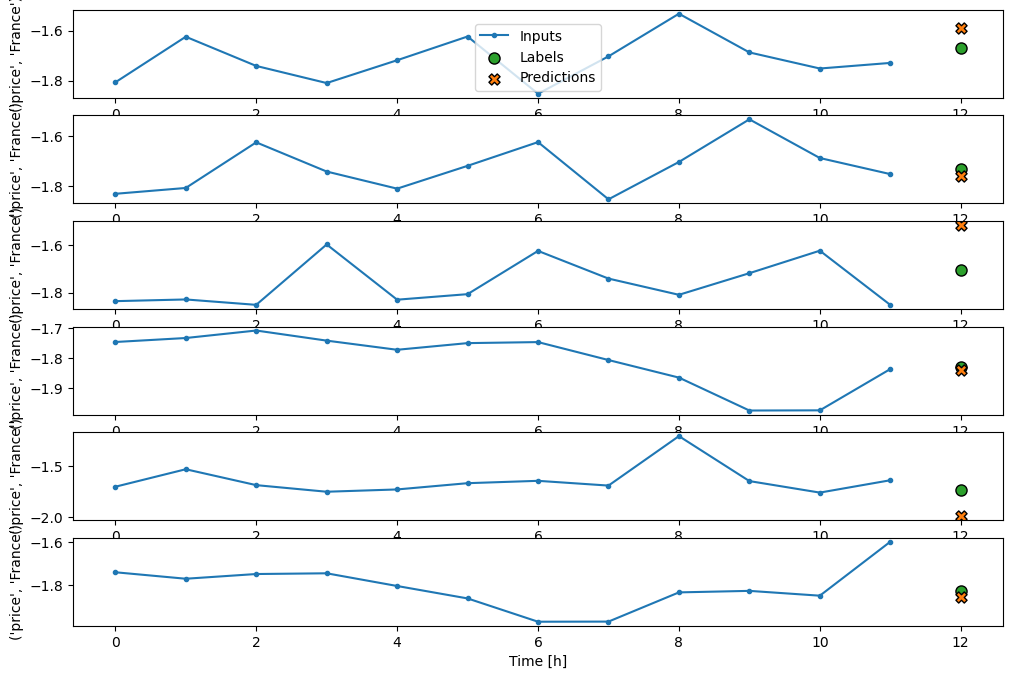

In [18]:
val_performance = {}
performance = {}

val_performance['1'] = m.evaluate(w.val)
performance['1'] = m.evaluate(w.test, verbose=0)
w.plot(m, plot_col=label_columns[0], max_subplots=6)